In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [2]:
data_path = './data/'

train = pd.read_csv(data_path + 'FIFA_train.csv')
test = pd.read_csv(data_path + 'FIFA_test.csv')
submission = pd.read_csv(data_path + 'submission.csv')

print(train.head())
print(train.shape)

   id          name  age      continent contract_until position prefer_foot  \
0   0      L. Messi   31  south america           2021       ST        left   
1   3        De Gea   27         europe           2020       GK       right   
2   7     L. Suárez   31  south america           2021       ST       right   
3   8  Sergio Ramos   32         europe           2020       DF       right   
4   9      J. Oblak   25         europe           2021       GK       right   

   reputation  stat_overall  stat_potential  stat_skill_moves        value  
0         5.0            94              94               4.0  110500000.0  
1         4.0            91              93               1.0   72000000.0  
2         5.0            91              91               3.0   80000000.0  
3         4.0            91              91               3.0   51000000.0  
4         3.0            90              93               1.0   68000000.0  
(8932, 12)


Data 전처리

In [3]:
# columns drop

train.drop(['id', 'name'], axis=1, inplace=True)
train

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0
...,...,...,...,...,...,...,...,...,...,...
8927,18,africa,2019,MF,right,1.0,48,63,3.0,60000.0
8928,19,europe,2020,DF,right,1.0,47,59,2.0,40000.0
8929,18,south america,2021,DF,right,1.0,47,64,2.0,50000.0
8930,18,europe,2021,GK,right,1.0,47,65,1.0,50000.0


In [4]:
# 'contract_until' column encoder


def value_change(train):
    year = []
    contract = []
    for i in train.contract_until.unique():
        
#         print(i)
#         print(len(i))
        if len(i) > 4:
#             print(i.split(','))
            a = i.split(' ')
            year.append(a)
            contract.append(i)
    for i, j in zip(contract, year):
#         print(i, j)
        train['contract_until'] = train['contract_until'].replace([i],j[2])
        

    return train.contract_until.unique()


value_change(train)


array(['2021', '2020', '2019', '2023', '2022', '2024', '2026', '2018',
       '2025'], dtype=object)

In [5]:
# 'contract_until' column, Dtype change

print(train.info())
train = train.astype({'contract_until':'int16'})
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               8932 non-null   int64  
 1   continent         8932 non-null   object 
 2   contract_until    8932 non-null   object 
 3   position          8932 non-null   object 
 4   prefer_foot       8932 non-null   object 
 5   reputation        8932 non-null   float64
 6   stat_overall      8932 non-null   int64  
 7   stat_potential    8932 non-null   int64  
 8   stat_skill_moves  8932 non-null   float64
 9   value             8932 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 697.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               8932 non-null   int64  
 1   contine

In [12]:
# One-Hot Encoder

train = pd.get_dummies(train, columns=['continent', 'position', 'prefer_foot', 'contract_until'])
train

,age,reputation,stat_overall,stat_potential,stat_skill_moves,value,continent_africa,continent_asia,continent_europe,continent_oceania,...,prefer_foot_right,contract_until_2018,contract_until_2019,contract_until_2020,contract_until_2021,contract_until_2022,contract_until_2023,contract_until_2024,contract_until_2025,contract_until_2026
0,31,5.0,94,94,4.0,110500000.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,27,4.0,91,93,1.0,72000000.0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
2,31,5.0,91,91,3.0,80000000.0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,32,4.0,91,91,3.0,51000000.0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
4,25,3.0,90,93,1.0,68000000.0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8927,18,1.0,48,63,3.0,60000.0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,0
8928,19,1.0,47,59,2.0,40000.0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
8929,18,1.0,47,64,2.0,50000.0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
8930,18,1.0,47,65,1.0,50000.0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0


In [6]:
train

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0
...,...,...,...,...,...,...,...,...,...,...
8927,18,africa,2019,MF,right,1.0,48,63,3.0,60000.0
8928,19,europe,2020,DF,right,1.0,47,59,2.0,40000.0
8929,18,south america,2021,DF,right,1.0,47,64,2.0,50000.0
8930,18,europe,2021,GK,right,1.0,47,65,1.0,50000.0


In [7]:
train['age'] = train['age'].astype('category')
train['age'] = train['age'].cat.codes

train['continent'] = train['continent'].astype('category')
train['continent'] = train['continent'].cat.codes

train['contract_until'] = train['contract_until'].astype('category')
train['contract_until'] = train['contract_until'].cat.codes

train['position'] = train['position'].astype('category')
train['position'] = train['position'].cat.codes

train['prefer_foot'] = train['prefer_foot'].astype('category')
train['prefer_foot'] = train['prefer_foot'].cat.codes

In [19]:
train.columns

Index(['age', 'continent', 'contract_until', 'position', 'prefer_foot',
       'reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves',
       'value'],
      dtype='object')

<AxesSubplot:>

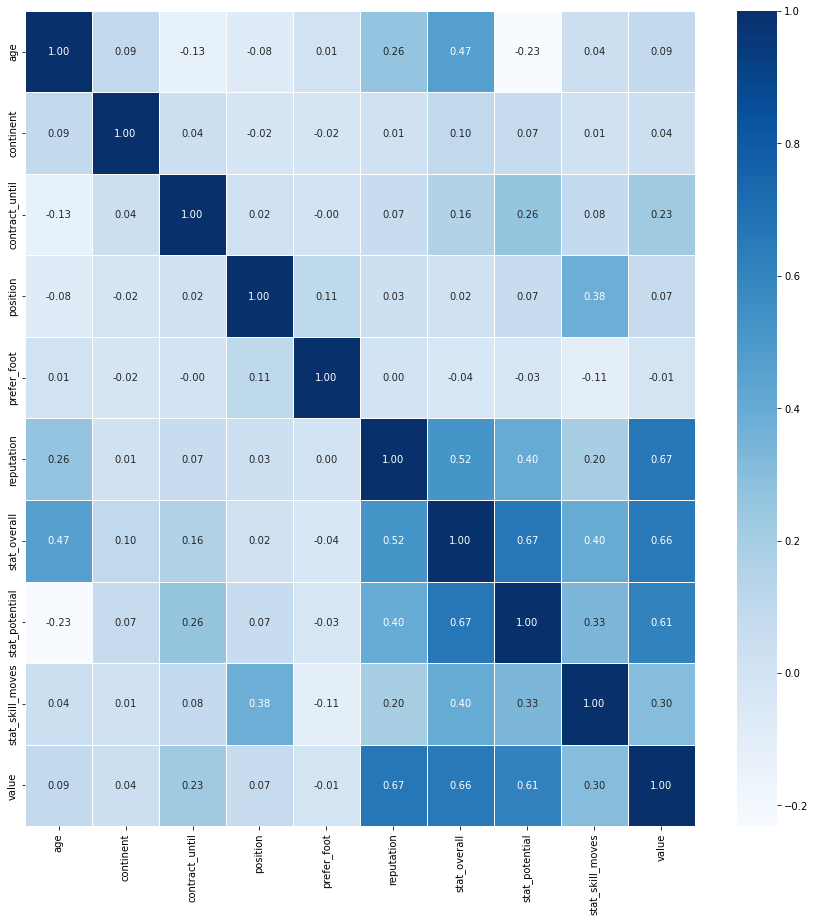

In [21]:
import seaborn as sns

k = train[['age', 'continent', 'contract_until', 'position', 'prefer_foot',
       'reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves',
       'value']]
plt.figure(figsize=(15,15))
sns.heatmap(data = k.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               8932 non-null   int8   
 1   continent         8932 non-null   int8   
 2   contract_until    8932 non-null   int8   
 3   position          8932 non-null   int8   
 4   prefer_foot       8932 non-null   int8   
 5   reputation        8932 non-null   float64
 6   stat_overall      8932 non-null   int64  
 7   stat_potential    8932 non-null   int64  
 8   stat_skill_moves  8932 non-null   float64
 9   value             8932 non-null   float64
dtypes: float64(3), int64(2), int8(5)
memory usage: 392.6 KB


In [23]:
model = Sequential()
model.add(Dense(10, activation='linear', input_shape=(9,)))
model.add(Dense(6, activation='linear'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                100       
                                                                 
 dense_7 (Dense)             (None, 6)                 66        
                                                                 
 dense_8 (Dense)             (None, 1)                 7         
                                                                 
Total params: 173
Trainable params: 173
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Call-back 함수
# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath='-{epoch:03d}-{loss:.4f}-{accuracy:.4f}.hdf5',
            monitor='loss', verbose=1, save_best_only=True, mode='min')

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='loss',factor=0.8,patience=3, verbose=1, min_lr=1e-8)

CALLBACK = [CP, LR]

In [26]:
from sklearn import datasets, preprocessing

from sklearn.model_selection import train_test_split
import gc

X = train.drop(['value'], axis=1)
y = train['value']

# Apply standard scaling on x_data
sc = preprocessing.StandardScaler()
x_data = sc.fit_transform(X)

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0xC0FFEE)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=0xC0FFEE)

# 6 : 2 : 2 = train : validation : test
print(train_X.shape, val_X.shape, test_X.shape, train_y.shape, val_y.shape, test_y.shape)
gc.collect()

(5716, 9) (1429, 9) (1787, 9) (5716,) (1429,) (1787,)


667

In [28]:
X = train[['reputation', 'stat_overall', 'stat_potential']]
y = train['value']

In [29]:
model.fit(x=train_X, y=train_y, epochs=100, shuffle=True, batch_size=3, callbacks=CALLBACK)

Epoch 1/100
1828/1906 [===========================>..] - ETA: 0s - loss: -59673222840320.0000 - accuracy: 0.0000e+00
Epoch 1: loss improved from inf to -65266738266112.00000, saving model to -001--65266738266112.0000-0.0000.hdf5
1906/1906 [==============================] - 1s 360us/step - loss: -65266738266112.0000 - accuracy: 0.0000e+00 - lr: 0.0100
Epoch 2/100
1849/1906 [============================>.] - ETA: 0s - loss: -794148311400448.0000 - accuracy: 0.0000e+00
Epoch 2: loss improved from -65266738266112.00000 to -830030548566016.00000, saving model to -002--830030548566016.0000-0.0000.hdf5
1906/1906 [==============================] - 1s 357us/step - loss: -830030548566016.0000 - accuracy: 0.0000e+00 - lr: 0.0100
Epoch 3/100
1796/1906 [===========================>..] - ETA: 0s - loss: -2904931732291584.0000 - accuracy: 0.0000e+00
Epoch 3: loss improved from -830030548566016.00000 to -2984282058391552.00000, saving model to -003--2984282058391552.0000-0.0000.hdf5
1906/1906 [=======

1846/1906 [============================>.] - ETA: 0s - loss: -675421059410821120.0000 - accuracy: 0.0000e+00
Epoch 22: loss improved from -594012050259181568.00000 to -675461672621572096.00000, saving model to -022--675461672621572096.0000-0.0000.hdf5
1906/1906 [==============================] - 1s 357us/step - loss: -675461672621572096.0000 - accuracy: 0.0000e+00 - lr: 0.0100
Epoch 23/100
1856/1906 [============================>.] - ETA: 0s - loss: -759898805515583488.0000 - accuracy: 0.0000e+00
Epoch 23: loss improved from -675461672621572096.00000 to -762462454314696704.00000, saving model to -023--762462454314696704.0000-0.0000.hdf5
1906/1906 [==============================] - 1s 355us/step - loss: -762462454314696704.0000 - accuracy: 0.0000e+00 - lr: 0.0100
Epoch 24/100
1854/1906 [============================>.] - ETA: 0s - loss: -862322711689428992.0000 - accuracy: 0.0000e+00
Epoch 24: loss improved from -762462454314696704.00000 to -855076586465001472.00000, saving model to -024

1906/1906 [==============================] - 1s 357us/step - loss: -4091372652030066688.0000 - accuracy: 0.0000e+00 - lr: 0.0100
Epoch 43/100
1848/1906 [============================>.] - ETA: 0s - loss: -4339085474942418944.0000 - accuracy: 0.0000e+00
Epoch 43: loss improved from -4091372652030066688.00000 to -4376797349385601024.00000, saving model to -043--4376797349385601024.0000-0.0000.hdf5
1906/1906 [==============================] - 1s 356us/step - loss: -4376797349385601024.0000 - accuracy: 0.0000e+00 - lr: 0.0100
Epoch 44/100
1849/1906 [============================>.] - ETA: 0s - loss: -4670697907001753600.0000 - accuracy: 0.0000e+00
Epoch 44: loss improved from -4376797349385601024.00000 to -4666522511595274240.00000, saving model to -044--4666522511595274240.0000-0.0000.hdf5
1906/1906 [==============================] - 1s 356us/step - loss: -4666522511595274240.0000 - accuracy: 0.0000e+00 - lr: 0.0100
Epoch 45/100
1819/1906 [===========================>..] - ETA: 0s - loss: -

1863/1906 [============================>.] - ETA: 0s - loss: -12958701108456325120.0000 - accuracy: 0.0000e+00
Epoch 63: loss improved from -12428241723635793920.00000 to -13014024135519502336.00000, saving model to -063--13014024135519502336.0000-0.0000.hdf5
1906/1906 [==============================] - 1s 359us/step - loss: -13014024135519502336.0000 - accuracy: 0.0000e+00 - lr: 0.0100
Epoch 64/100
1859/1906 [============================>.] - ETA: 0s - loss: -13671788275138822144.0000 - accuracy: 0.0000e+00
Epoch 64: loss improved from -13014024135519502336.00000 to -13618995224331157504.00000, saving model to -064--13618995224331157504.0000-0.0000.hdf5
1906/1906 [==============================] - 1s 355us/step - loss: -13618995224331157504.0000 - accuracy: 0.0000e+00 - lr: 0.0100
Epoch 65/100
1864/1906 [============================>.] - ETA: 0s - loss: -14244200625628774400.0000 - accuracy: 0.0000e+00
Epoch 65: loss improved from -13618995224331157504.00000 to -14220326929654874112.0

1906/1906 [==============================] - 1s 356us/step - loss: -28791833475174891520.0000 - accuracy: 0.0000e+00 - lr: 0.0100
Epoch 84/100
1856/1906 [============================>.] - ETA: 0s - loss: -29661402037210841088.0000 - accuracy: 0.0000e+00
Epoch 84: loss improved from -28791833475174891520.00000 to -29805369890728574976.00000, saving model to -084--29805369890728574976.0000-0.0000.hdf5
1906/1906 [==============================] - 1s 355us/step - loss: -29805369890728574976.0000 - accuracy: 0.0000e+00 - lr: 0.0100
Epoch 85/100
1820/1906 [===========================>..] - ETA: 0s - loss: -30637192218582974464.0000 - accuracy: 0.0000e+00
Epoch 85: loss improved from -29805369890728574976.00000 to -30862572311067754496.00000, saving model to -085--30862572311067754496.0000-0.0000.hdf5
1906/1906 [==============================] - 1s 362us/step - loss: -30862572311067754496.0000 - accuracy: 0.0000e+00 - lr: 0.0100
Epoch 86/100
1861/1906 [============================>.] - ETA: 0